In [61]:
# Importing necessary libraries and modules
import warnings  # Import the 'warnings' module for handling warnings
warnings.filterwarnings("ignore")  # Ignore warnings during execution

import gc  # Import the 'gc' module for garbage collection
import numpy as np  # Import NumPy for numerical operations
import pandas as pd  # Import Pandas for data manipulation
import itertools  # Import 'itertools' for iterators and looping
from collections import Counter  # Import 'Counter' for counting elements
import matplotlib.pyplot as plt  # Import Matplotlib for data visualization
from sklearn.metrics import (  # Import various metrics from scikit-learn
    accuracy_score,  # For calculating accuracy
    roc_auc_score,  # For ROC AUC score
    confusion_matrix,  # For confusion matrix
    classification_report,  # For classification report
    f1_score  # For F1 score
)

# Import custom modules and classes
from imblearn.over_sampling import RandomOverSampler # import RandomOverSampler
import accelerate # Import the 'accelerate' module
import evaluate  # Import the 'evaluate' module
from datasets import Dataset, Image, ClassLabel  # Import custom 'Dataset', 'ClassLabel', and 'Image' classes
from transformers import (  # Import various modules from the Transformers library
    TrainingArguments,  # For training arguments
    Trainer,  # For model training
    ViTImageProcessor,  # For processing image data with ViT models
    ViTForImageClassification,  # ViT model for image classification
    DefaultDataCollator  # For collating data in the default way
)
import torch  # Import PyTorch for deep learning
from torch.utils.data import DataLoader  # For creating data loaders
from torchvision.transforms import (  # Import image transformation functions
    CenterCrop,  # Center crop an image
    Compose,  # Compose multiple image transformations
    Normalize,  # Normalize image pixel values
    RandomRotation,  # Apply random rotation to images
    RandomResizedCrop,  # Crop and resize images randomly
    RandomHorizontalFlip,  # Apply random horizontal flip
    RandomAdjustSharpness,  # Adjust sharpness randomly
    Resize,  # Resize images
    ToTensor  # Convert images to PyTorch tensors
)
import os
from sklearn.model_selection import train_test_split, KFold

# Import the necessary module from the Python Imaging Library (PIL).
from PIL import ImageFile

# Enable the option to load truncated images.
# This setting allows the PIL library to attempt loading images even if they are corrupted or incomplete.
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [62]:
# Define emotion labels
emotions = ['angry', 'fear', 'happy', 'sad', 'surprise']
num_classes = len(emotions)

# Define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom Dataset class to handle loading and transforming images
class EmotionDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Load and split data into training and validation sets
train_dir = 'data/train'
file_names = []
labels = []
for emotion in emotions:
    emotion_dir = os.path.join(train_dir, emotion)
    for img_file in os.listdir(emotion_dir):
        file_path = os.path.join(emotion_dir, img_file)
        file_names.append(file_path)
        labels.append(emotion)

print(len(file_names), len(labels))
df = pd.DataFrame({'image': file_names, 'label': labels})
print(df.shape)
train_files, val_files, train_labels, val_labels = train_test_split(file_names, labels, test_size=0.2, random_state=42)

9108 9108
(9108, 2)


In [63]:
df.head()

,image,label
0,data/train\angry\AffectNet10.jpg,angry
1,data/train\angry\AffectNet101.jpg,angry
2,data/train\angry\AffectNet103.jpg,angry
3,data/train\angry\AffectNet106.jpg,angry
4,data/train\angry\AffectNet107.jpg,angry


In [64]:
# random oversampling of minority class
# 'y' contains the target variable (label) we want to predict
y = df[['label']]

# Drop the 'label' column from the DataFrame 'df' to separate features from the target variable
df = df.drop(['label'], axis=1)

# Create a RandomOverSampler object with a specified random seed (random_state=83)
ros = RandomOverSampler(random_state=83)

# Use the RandomOverSampler to resample the dataset by oversampling the minority class
# 'df' contains the feature data, and 'y_resampled' will contain the resampled target variable
df, y_resampled = ros.fit_resample(df, y)

# Delete the original 'y' variable to save memory as it's no longer needed
del y

# Add the resampled target variable 'y_resampled' as a new 'label' column in the DataFrame 'df'
df['label'] = y_resampled

# Delete the 'y_resampled' variable to save memory as it's no longer needed
del y_resampled

# Perform garbage collection to free up memory used by discarded variables
gc.collect()

print(df.shape)

(10000, 2)


In [65]:
# Create a dataset from a Pandas DataFrame.
dataset = Dataset.from_pandas(df).cast_column("image", Image())

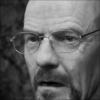

In [66]:
# Display the first image in the dataset
dataset[5]["image"]

In [67]:
# Extracting a subset of elements from the 'labels' list using slicing.
# The slicing syntax [:5] selects elements from the beginning up to (but not including) the 5th element.
# This will give us the first 5 elements of the 'labels' list.
# The result will be a new list containing these elements.
labels_subset = labels[:5]

# Printing the subset of labels to inspect the content.
print(labels_subset)

['angry', 'angry', 'angry', 'angry', 'angry']


In [68]:
# Create a list of unique labels by converting 'labels' to a set and then back to a list
labels_list = emotions

# Initialize empty dictionaries to map labels to IDs and vice versa
label2id, id2label = dict(), dict()

# Iterate over the unique labels and assign each label an ID, and vice versa
for i, label in enumerate(labels_list):
    label2id[label] = i  # Map the label to its corresponding ID
    id2label[i] = label  # Map the ID to its corresponding label

# Print the resulting dictionaries for reference
print("Mapping of IDs to Labels:", id2label, '\n')
print("Mapping of Labels to IDs:", label2id)

Mapping of IDs to Labels: {0: 'angry', 1: 'fear', 2: 'happy', 3: 'sad', 4: 'surprise'} 

Mapping of Labels to IDs: {'angry': 0, 'fear': 1, 'happy': 2, 'sad': 3, 'surprise': 4}


In [69]:
# Creating classlabels to match labels to IDs
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

# Mapping labels to IDs
def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

dataset = dataset.map(map_label2id, batched=True)

# Casting label column to ClassLabel Object
dataset = dataset.cast_column('label', ClassLabels)

# Splitting the dataset into training and testing sets using an 60-40 split ratio.
dataset = dataset.train_test_split(test_size=0.2, shuffle=True, stratify_by_column="label")

# Extracting the training data from the split dataset.
train_data = dataset['train']

# Extracting the testing data from the split dataset.
test_data = dataset['test']

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [70]:
# Define the pre-trained ViT model string
model_str = "dima806/facial_emotions_image_detection" # 'google/vit-base-patch16-224-in21k'

# Create a processor for ViT model input from the pre-trained model
processor = ViTImageProcessor.from_pretrained(model_str)

# Retrieve the image mean and standard deviation used for normalization
image_mean, image_std = processor.image_mean, processor.image_std

# Get the size (height) of the ViT model's input images
size = processor.size["height"]
print("Size: ", size)

# Define a normalization transformation for the input images
normalize = Normalize(mean=image_mean, std=image_std)

# Define a set of transformations for training data
_train_transforms = Compose(
    [
        Resize((size, size)),             # Resize images to the ViT model's input size
        RandomRotation(90),               # Apply random rotation
        RandomAdjustSharpness(2),         # Adjust sharpness randomly
        RandomHorizontalFlip(0.5),        # Random horizontal flip
        ToTensor(),                       # Convert images to tensors
        normalize                         # Normalize images using mean and std
    ]
)

# Define a set of transformations for validation data
_val_transforms = Compose(
    [
        Resize((size, size)),             # Resize images to the ViT model's input size
        ToTensor(),                       # Convert images to tensors
        normalize                         # Normalize images using mean and std
    ]
)

# Define a function to apply training transformations to a batch of examples
def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

# Define a function to apply validation transformations to a batch of examples
def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

Size:  224


In [71]:
# Set the transforms for the training data
train_data.set_transform(train_transforms)

# Set the transforms for the test/validation data
test_data.set_transform(val_transforms)

In [72]:
# Define a collate function that prepares batched data for model training.
def collate_fn(examples):
    # Stack the pixel values from individual examples into a single tensor.
    pixel_values = torch.stack([example["pixel_values"] for example in examples])

    # Convert the label strings in examples to corresponding numeric IDs using label2id dictionary.
    labels = torch.tensor([example['label'] for example in examples])

    # Return a dictionary containing the batched pixel values and labels.
    return {"pixel_values": pixel_values, "labels": labels}


In [73]:
# Create a ViTForImageClassification model from a pretrained checkpoint with a specified number of output labels.
model = ViTForImageClassification.from_pretrained(model_str, num_labels=len(labels_list))

# Configure the mapping of class labels to their corresponding indices for later reference.
model.config.id2label = id2label
model.config.label2id = label2id

# Calculate and print the number of trainable parameters in millions for the model.
print(model.num_parameters(only_trainable=True) / 1e6)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at dima806/facial_emotions_image_detection and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([7]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([7, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


85.802501


In [74]:
# Load the accuracy metric from a module named 'evaluate'
accuracy = evaluate.load("accuracy")

# Define a function 'compute_metrics' to calculate evaluation metrics
def compute_metrics(eval_pred):
    # Extract model predictions from the evaluation prediction object
    predictions = eval_pred.predictions

    # Extract true labels from the evaluation prediction object
    label_ids = eval_pred.label_ids

    # Calculate accuracy using the loaded accuracy metric
    # Convert model predictions to class labels by selecting the class with the highest probability (argmax)
    predicted_labels = predictions.argmax(axis=1)

    # Calculate accuracy score by comparing predicted labels to true labels
    acc_score = accuracy.compute(predictions=predicted_labels, references=label_ids)['accuracy']

    # Return the computed accuracy as a dictionary with the key "accuracy"
    return {
        "accuracy": acc_score
    }

In [75]:
# Define the name of the evaluation metric to be used during training and evaluation.
metric_name = "accuracy"

# Define the name of the model, which will be used to create a directory for saving model checkpoints and outputs.
model_name = "facial_emotions_image_detection"

# Define the number of training epochs for the model.
num_train_epochs = 5

# Create an instance of TrainingArguments to configure training settings.
args = TrainingArguments(
    # Specify the directory where model checkpoints and outputs will be saved.
    output_dir=model_name,

    # Specify the directory where training logs will be stored.
    logging_dir='./logs',

    # Define the evaluation strategy, which is performed at the end of each epoch.
    evaluation_strategy="epoch",

    # Set the learning rate for the optimizer.
    learning_rate=1e-7,

    # Define the batch size for training on each device.
    per_device_train_batch_size=32,

    # Define the batch size for evaluation on each device.
    per_device_eval_batch_size=8,

    # Specify the total number of training epochs.
    num_train_epochs=num_train_epochs,

    # Apply weight decay to prevent overfitting.
    weight_decay=0.02,

    # Set the number of warm-up steps for the learning rate scheduler.
    warmup_steps=50,

    # Disable the removal of unused columns from the dataset.
    remove_unused_columns=False,

    # Define the strategy for saving model checkpoints (per epoch in this case).
    save_strategy='epoch',

    # Load the best model at the end of training.
    load_best_model_at_end=True,

    # Limit the total number of saved checkpoints to save space.
    save_total_limit=1,

    # Specify that training progress should not be reported.
    report_to="none"
)

In [76]:
# Create a Trainer instance for fine-tuning a language model.

# - `model`: The pre-trained language model to be fine-tuned.
# - `args`: Configuration settings and hyperparameters for training.
# - `train_dataset`: The dataset used for training the model.
# - `eval_dataset`: The dataset used for evaluating the model during training.
# - `data_collator`: A function that defines how data batches are collated and processed.
# - `compute_metrics`: A function for computing custom evaluation metrics.
# - `tokenizer`: The tokenizer used for processing text data.

trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

In [77]:
# Start training the model using the trainer object.
trainer.train()

Epoch,Training Loss,Validation Loss


TrainOutput(global_step=1250, training_loss=1.5630576416015625, metrics={'train_runtime': 6613.3317, 'train_samples_per_second': 6.048, 'train_steps_per_second': 0.189, 'total_flos': 3.09976292892672e+18, 'train_loss': 1.5630576416015625, 'epoch': 5.0})

In [78]:
# Evaluate the pre-training model's performance on a test dataset.
# This function calculates various metrics such as accuracy, loss, etc.,
# to assess how well the model is performing on unseen data.

trainer.evaluate()

{'eval_loss': 1.5366010665893555,
 'eval_accuracy': 0.493,
 'eval_runtime': 99.5292,
 'eval_samples_per_second': 20.095,
 'eval_steps_per_second': 2.512,
 'epoch': 5.0}

In [79]:
# Use the trained 'trainer' to make predictions on the 'test_data'.
outputs = trainer.predict(test_data)

# Print the metrics obtained from the prediction outputs.
print(outputs.metrics)

{'test_loss': 1.5366010665893555, 'test_accuracy': 0.493, 'test_runtime': 97.6033, 'test_samples_per_second': 20.491, 'test_steps_per_second': 2.561}


Accuracy: 0.4930
F1 Score: 0.4487


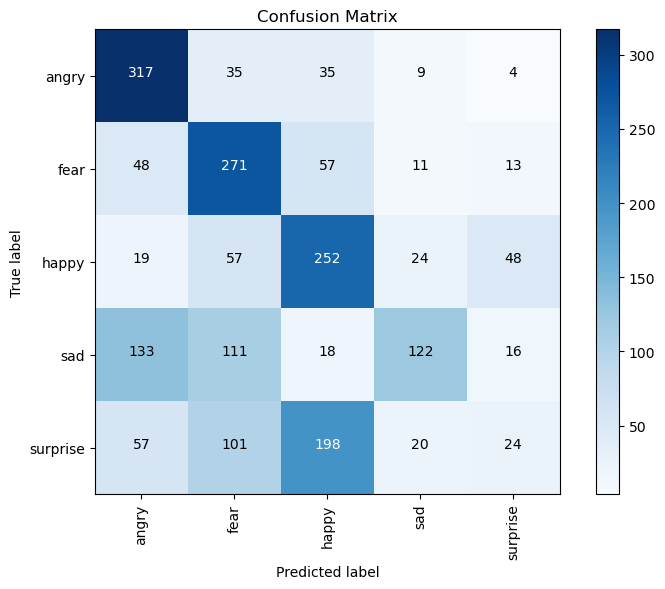


Classification report:

              precision    recall  f1-score   support

       angry     0.5523    0.7925    0.6509       400
        fear     0.4713    0.6775    0.5559       400
       happy     0.4500    0.6300    0.5250       400
         sad     0.6559    0.3050    0.4164       400
    surprise     0.2286    0.0600    0.0950       400

    accuracy                         0.4930      2000
   macro avg     0.4716    0.4930    0.4487      2000
weighted avg     0.4716    0.4930    0.4487      2000


In [80]:
# Extract the true labels from the model outputs
y_true = outputs.label_ids

# Predict the labels by selecting the class with the highest probability
y_pred = outputs.predictions.argmax(1)

# Define a function to plot a confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8)):
    """
    This function plots a confusion matrix.

    Parameters:
        cm (array-like): Confusion matrix as returned by sklearn.metrics.confusion_matrix.
        classes (list): List of class names, e.g., ['Class 0', 'Class 1'].
        title (str): Title for the plot.
        cmap (matplotlib colormap): Colormap for the plot.
    """
    # Create a figure with a specified size
    plt.figure(figsize=figsize)

    # Display the confusion matrix as an image with a colormap
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Define tick marks and labels for the classes on the axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.0f'
    # Add text annotations to the plot indicating the values in the cells
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # Label the axes
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Ensure the plot layout is tight
    plt.tight_layout()
    # Display the plot
    plt.show()

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

# Display accuracy and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Get the confusion matrix if there are a small number of labels
if len(labels_list) <= 150:
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix using the defined function
    plot_confusion_matrix(cm, labels_list, figsize=(8, 6))

# Finally, display classification report
print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))

In [21]:
# Save the trained model: This line of code is responsible for saving the model
# that has been trained using the trainer object. It will serialize the model
# and its associated weights, making it possible to reload and use the model
# in the future without the need to retrain it.
trainer.save_model()

In [22]:
# Import the 'pipeline' function from the 'transformers' library.
from transformers import pipeline

# Create a pipeline for image classification tasks. 
# You need to specify the 'model_name' and the 'device' to use for inference.
# - 'model_name': The name of the pre-trained model to be used for image classification.
# - 'device': Specifies the device to use for running the model (0 for GPU, -1 for CPU).
pipe = pipeline('image-classification', model=model_name, device=0)

AssertionError: Torch not compiled with CUDA enabled

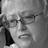

In [23]:
# Accessing an image from the 'test_data' dataset using index 1.
image = test_data[1]["image"]

# Displaying the 'image' variable.
image

In [24]:
# Apply the 'pipe' function to process the 'image' variable.
pipe(image)

NameError: name 'pipe' is not defined

In [25]:
# This line of code accesses the "label" attribute of a specific element in the test_data list.
# It's used to retrieve the actual label associated with a test data point.
id2label[test_data[1]["label"]]

'sad'

In [ ]:
#TODO
# - Set up ViT Model without pretrained model with weird labels I dont want
# - Try Swin transformer